<a href="https://colab.research.google.com/github/SolFreire/Cellshealthyclassifierwithrandomforest/blob/main/ClassificadorSa%C3%BAdeCelular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Primeiramente para a tarefa de classificação ficar mais tangível escolhi um dataset real para aplicar os conceitos e construir melhor a prática proposta, me atentei a ter mais de 1000 entradas como exigência e escolhi um dataset sobre células para as classificar em tumores ou saudáveis

In [38]:
!pip install kaggle



In [39]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!ls /content


Gene_Expression_Analysis_and_Disease_Relationship_Synthetic.csv
kaggle.json
sample_data
scrna-seq-cancer-microenvironment-classification.zip


In [40]:
!kaggle datasets download -d ylmzasel/scrna-seq-cancer-microenvironment-classification


Dataset URL: https://www.kaggle.com/datasets/ylmzasel/scrna-seq-cancer-microenvironment-classification
License(s): CC0-1.0
scrna-seq-cancer-microenvironment-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [54]:
 !unzip scrna-seq-cancer-microenvironment-classification.zip


Archive:  scrna-seq-cancer-microenvironment-classification.zip
replace Gene_Expression_Analysis_and_Disease_Relationship_Synthetic.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [55]:
!ls

Gene_Expression_Analysis_and_Disease_Relationship_Synthetic.csv
kaggle.json
sample_data
scrna-seq-cancer-microenvironment-classification.zip


In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score


In [57]:

df = pd.read_csv("Gene_Expression_Analysis_and_Disease_Relationship_Synthetic.csv")
df.head()


,Cell_ID,Cell_Type,Disease_Status,Gene_E_Housekeeping,Gene_A_Oncogene,Gene_B_Immune,Gene_C_Stromal,Gene_D_Therapy,Pathway_Score_Inflam,UMAP_1
0,C0001,T_Cell,Tumor,5.565866,4.546474,10.532535,2.113285,0.951138,9.580415,7.818137
1,C0002,T_Cell,Tumor,5.351163,3.840752,10.642705,4.361618,0.952454,10.540695,8.298277
2,C0003,T_Cell,Tumor,4.935363,2.271616,10.389736,2.839926,1.906194,8.416975,7.158779
3,C0004,Cancer,Tumor,4.095084,14.881377,3.268237,3.204284,9.922546,7.357785,0.016234
4,C0005,Fibroblast,Tumor,4.669715,5.444694,2.561298,14.046708,3.126553,3.372407,11.646391


In [58]:
df.describe()

,Gene_E_Housekeeping,Gene_A_Oncogene,Gene_B_Immune,Gene_C_Stromal,Gene_D_Therapy,Pathway_Score_Inflam,UMAP_1
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,5.002702,7.319094,5.982890,6.852504,4.952360,7.043063,6.516869
std,0.495695,4.959009,4.383173,4.861748,3.692807,3.424917,3.970911
min,3.436678,1.087581,1.015551,1.176086,0.500000,1.000000,-0.799966
25%,4.658408,3.286695,2.525109,3.011726,2.004656,4.276713,1.990183
50%,4.979579,4.773690,3.517219,4.144346,3.143158,6.732012,7.010630
75%,5.326971,12.947793,11.269680,12.645769,9.255951,9.795390,10.563544
max,7.165827,21.508750,16.901272,19.199503,15.083534,17.994128,13.756952


1.


In [59]:
df.isnull().sum()


,0
Cell_ID,0
Cell_Type,0
Disease_Status,0
Gene_E_Housekeeping,0
Gene_A_Oncogene,0
Gene_B_Immune,0
Gene_C_Stromal,0
Gene_D_Therapy,0
Pathway_Score_Inflam,0
UMAP_1,0


ficou interessante de aplicar o random forest pela ausência de variáveis com valores ausentes

In [47]:
df['Cell_Type'].value_counts()


,count
Cell_Type,
T_Cell,1000
Cancer,1000
Fibroblast,1000


In [48]:
df['Disease_Status'].value_counts()


,count
Disease_Status,
Tumor,2595
Healthy_Control,405


Vemos que o dataset está desbalanceado nesse aspecto

In [60]:
df['Disease_Status'] = df['Disease_Status'].map({'Tumor': 1, 'Healthy_Control': 0})


In [50]:
df = df.drop(columns=['Cell_ID'])


In [51]:
df.head()

,Cell_Type,Disease_Status,Gene_E_Housekeeping,Gene_A_Oncogene,Gene_B_Immune,Gene_C_Stromal,Gene_D_Therapy,Pathway_Score_Inflam,UMAP_1
0,T_Cell,1,5.565866,4.546474,10.532535,2.113285,0.951138,9.580415,7.818137
1,T_Cell,1,5.351163,3.840752,10.642705,4.361618,0.952454,10.540695,8.298277
2,T_Cell,1,4.935363,2.271616,10.389736,2.839926,1.906194,8.416975,7.158779
3,Cancer,1,4.095084,14.881377,3.268237,3.204284,9.922546,7.357785,0.016234
4,Fibroblast,1,4.669715,5.444694,2.561298,14.046708,3.126553,3.372407,11.646391


In [89]:
mapping = {
    'Cancer': 0,
    'Fibroblast': 1,
    'T_Cell': 2
}
df['Cell_Type'] = df['Cell_Type'].map(mapping)
y = df['Cell_Type_encoded']


In [62]:
print(encoder.classes_)

['Cancer' 'Fibroblast' 'T_Cell']


In [77]:
df.head()


,Cell_ID,Cell_Type,Disease_Status,Gene_E_Housekeeping,Gene_A_Oncogene,Gene_B_Immune,Gene_C_Stromal,Gene_D_Therapy,Pathway_Score_Inflam,UMAP_1,Cell_Type_encoded
0,C0001,NaN,1,5.565866,4.546474,10.532535,2.113285,0.951138,9.580415,7.818137,2
1,C0002,NaN,1,5.351163,3.840752,10.642705,4.361618,0.952454,10.540695,8.298277,2
2,C0003,NaN,1,4.935363,2.271616,10.389736,2.839926,1.906194,8.416975,7.158779,2
3,C0004,NaN,1,4.095084,14.881377,3.268237,3.204284,9.922546,7.357785,0.016234,0
4,C0005,NaN,1,4.669715,5.444694,2.561298,14.046708,3.126553,3.372407,11.646391,1


In [87]:
X = df.drop(columns=['Cell_Type', 'Cell_Type_encoded','Cell_ID'])

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [84]:

print(df.select_dtypes(include=['object']).columns)


Index(['Cell_ID'], dtype='object')


In [91]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [92]:
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       200
           2       1.00      1.00      1.00       200

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

[[200   0   0]
 [  0 200   0]
 [  0   0 200]]


Apesar do dataset ser grande creio que a coluna status da doença entrega facilmente uma classe, a Quantidade de arvores também pode ter influenciado por ser um dataset relativamente pequeno. Vamos explorar essa segunda opção


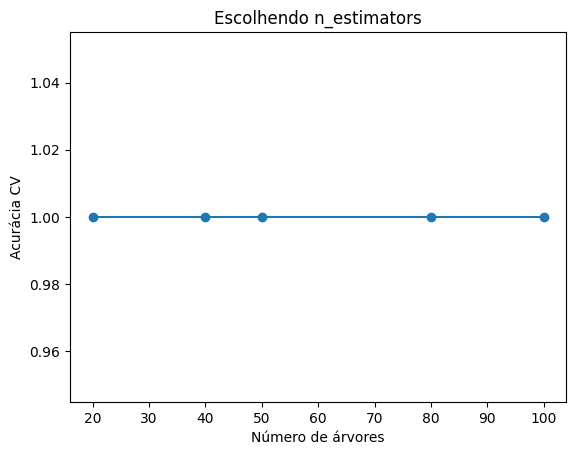

In [95]:
import matplotlib.pyplot as plt

scores = []
n_trees = [20, 40, 50, 80, 100]

for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    cv_score = cross_val_score(rf, X_train, y_train, cv=5).mean()
    scores.append(cv_score)

plt.plot(n_trees, scores, marker='o')
plt.xlabel('Número de árvores')
plt.ylabel('Acurácia CV')
plt.title('Escolhendo n_estimators')
plt.show()

Vou tentar tirar a coluna que suspeito que esteja entregando as cartas

In [96]:
X = df.drop(columns=['Cell_Type', 'Cell_Type_encoded','Cell_ID','Disease_Status'])

In [97]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

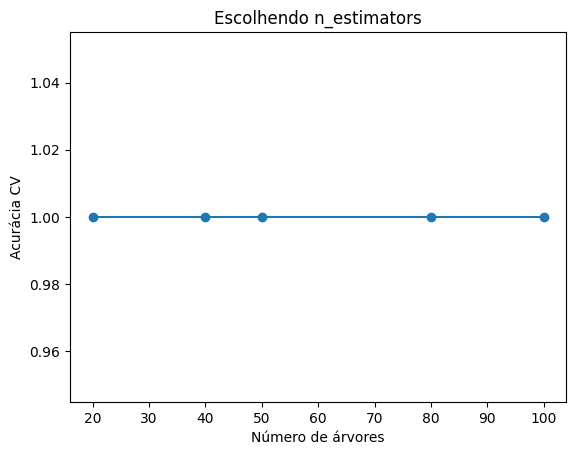

In [98]:
import matplotlib.pyplot as plt

scores = []
n_trees = [20, 40, 50, 80, 100]

for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    cv_score = cross_val_score(rf, X_train, y_train, cv=5).mean()
    scores.append(cv_score)

plt.plot(n_trees, scores, marker='o')
plt.xlabel('Número de árvores')
plt.ylabel('Acurácia CV')
plt.title('Escolhendo n_estimators')
plt.show()

In [99]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [101]:


correlations = X_train.corrwith(y_train)
print(correlations.sort_values(ascending=False))


Gene_B_Immune           0.843303
UMAP_1                  0.567896
Pathway_Score_Inflam    0.502209
Gene_C_Stromal          0.006607
Gene_E_Housekeeping    -0.005896
Gene_A_Oncogene        -0.830720
Gene_D_Therapy         -0.887014
dtype: float64


Creio que o dataset tenha entregado uma tarefa muito fácil pois acho que garanti boa separação entre treino e teste acima. O modelo foi tão bem que estou desconfiada de seu resultado. Analisando o modelo sabemos que : o n_estimators, que define o número de árvores na floresta, e o max_depth, que limita a profundidade máxima de cada árvore. Enquanto mais árvores tendem a reduzir a variância do modelo, profundidades excessivas podem levar ao overfitting, e profundidades muito pequenas podem resultar em underfitting. Para medir a eficácia do classificador, foram utilizadas métricas como acurácia, precisão, recall e F1-score, permitindo avaliar tanto a performance global quanto o desempenho individual de cada classe.
O ajuste de hiperparâmetros, incluindo o número de árvores,foi explorado para investigar a sua interferência na acurácia.
Por fim, a experiência ressaltou a importância de prevenir overfitting e de garantir que o modelo seja capaz de generalizar para novos dados, assegurando que as previsões reflitam padrões reais e não apenas peculiaridades do conjunto utilizado para treinamento.